# CS - Graphical Models in Finance

# Glasso

In [1]:
from sklearn.covariance import graphical_lasso, empirical_covariance, GraphicalLasso, GraphicalLassoCV, ledoit_wolf
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

### Importing data

In [2]:
df_prices = pd.read_csv('../data/cleaned_assets_price_volume_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/cleaned_assets_price_volume_data.csv'

In [ ]:
df_prices

,Date,Open,High,Low,Close,Volume,Ticker,Capital Gains
0,2003-01-02,-1.622976,-1.629134,-1.652047,-1.657231,-0.731993,000001.SS,NaN
1,2003-01-03,-1.658247,-1.661550,-1.657638,-1.658131,-0.731993,000001.SS,NaN
2,2003-01-04,-1.658247,-1.661550,-1.657638,-1.658131,-0.731993,000001.SS,NaN
3,2003-01-05,-1.658247,-1.661550,-1.657638,-1.658131,-0.731993,000001.SS,NaN
4,2003-01-06,-1.655760,-1.648382,-1.658969,-1.640642,-0.731993,000001.SS,NaN
...,...,...,...,...,...,...,...,...
5212153,2025-03-08,3.291949,3.325282,3.300552,3.335094,-0.760480,ZURN.SW,NaN
5212154,2025-03-09,3.291949,3.325282,3.300552,3.335094,-0.760480,ZURN.SW,NaN
5212155,2025-03-10,3.364173,3.366086,3.368204,3.394135,-0.962655,ZURN.SW,NaN
5212156,2025-03-11,3.395360,3.370982,3.351704,3.318694,-0.777827,ZURN.SW,NaN


We remove unused columns

In [ ]:
df_prices = df_prices.drop(columns=['Capital Gains', 'Volume'])
df_prices

,Date,Open,High,Low,Close,Ticker
0,2003-01-02,-1.622976,-1.629134,-1.652047,-1.657231,000001.SS
1,2003-01-03,-1.658247,-1.661550,-1.657638,-1.658131,000001.SS
2,2003-01-04,-1.658247,-1.661550,-1.657638,-1.658131,000001.SS
3,2003-01-05,-1.658247,-1.661550,-1.657638,-1.658131,000001.SS
4,2003-01-06,-1.655760,-1.648382,-1.658969,-1.640642,000001.SS
...,...,...,...,...,...,...
5212153,2025-03-08,3.291949,3.325282,3.300552,3.335094,ZURN.SW
5212154,2025-03-09,3.291949,3.325282,3.300552,3.335094,ZURN.SW
5212155,2025-03-10,3.364173,3.366086,3.368204,3.394135,ZURN.SW
5212156,2025-03-11,3.395360,3.370982,3.351704,3.318694,ZURN.SW


In [ ]:
df_mean_std = pd.read_csv('../data/assets_default_mean_std_data.csv')
df_mean_std

,Ticker,Open_mean,Open_std,High_mean,High_std,Low_mean,Low_std,Close_mean,Close_std,Volume_mean,Volume_std
0,000001.SS,2720.952665,846.297141,2744.256785,855.001950,2698.080982,835.698185,2724.086145,846.868132,1.764160e+05,2.410078e+05
1,0001.HK,43.500155,15.979528,43.904025,16.066757,43.066426,15.873576,43.486960,15.959315,6.825908e+06,4.225270e+06
2,0002.HK,41.602704,16.977079,41.864692,17.080063,41.301743,16.864127,41.593455,16.981717,3.209230e+06,2.013155e+06
3,0011.HK,80.262320,32.917319,80.880009,33.181514,79.536954,32.605017,80.233542,32.918423,1.939968e+06,1.451897e+06
4,0019.HK,43.668868,13.309214,44.123642,13.415283,43.180365,13.180119,43.656727,13.285411,2.068948e+06,1.490160e+06
...,...,...,...,...,...,...,...,...,...,...,...
638,XOM,52.906418,23.051966,53.389110,23.263616,52.417949,22.841870,52.914536,23.048264,1.893203e+07,1.061677e+07
639,YUM,53.818562,40.815954,54.283980,41.121623,53.354176,40.505135,53.832118,40.814962,3.767305e+06,2.760226e+06
640,ZBH,85.466379,31.771407,86.319182,32.030967,84.598984,31.466763,85.481966,31.744263,1.602386e+06,1.001153e+06
641,ZBRA,129.940497,136.529530,131.588353,138.179120,128.148559,134.584790,129.938581,136.449423,4.354248e+05,4.366121e+05


We define a function to get data on a lower interval of time, and standardize the data on the interval

In [ ]:
def get_stdz_val_time_range(df, num_years, df_mean_std, ticker_col, date_col, cols_to_standardize, num_months=0, stdz=True):
    # Defining the end and start date for the time range
    end_date = df['Date'].max()
    start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=num_years, months=num_months)).strftime('%Y-%m-%d')
    assets = df_mean_std[ticker_col].unique()

    # Filtering the DataFrame to only include the specified time range
    df_result = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()

    # Merging the DataFrame with the mean and std DataFrame
    df_result = df_result.merge(df_mean_std, on=ticker_col, suffixes=('', '_ref'))

    for col in cols_to_standardize:
            mean_col = col + "_mean"
            std_col = col + "_std"
            df_result[col] = df_result[col] * df_result[std_col] + df_result[mean_col]

    df_result = df_result.drop(columns=[col + "_mean" for col in (cols_to_standardize + ['Volume'])])
    df_result = df_result.drop(columns=[col + "_std" for col in (cols_to_standardize + ['Volume'])])

    if not stdz:
        return df_result, df_mean_std, start_date, end_date

    new_mean_std = []
    for asset in tqdm(assets):
        # Retrieving data for the current asset
        asset_data = df_result[df_result[ticker_col] == asset]
        mean = asset_data[cols_to_standardize].mean()
        std = asset_data[cols_to_standardize].std()

        # Retrieving the mean and std for the current asset
        temp_new_mean_std_val =  {ticker_col: asset}
        temp_new_mean_std_val.update({col + "_mean": mean[col] for col in cols_to_standardize})
        temp_new_mean_std_val.update({col + "_std": std[col] for col in cols_to_standardize})

        # Adding the new mean and std to the list
        new_mean_std.append(temp_new_mean_std_val)

        # Standardizing the data
        for col in cols_to_standardize:
            df_result.loc[df_result[ticker_col] == asset, col] = (df_result.loc[df_result[ticker_col] == asset, col] - mean[col]) / std[col]


    return df_result, pd.DataFrame(new_mean_std, columns=['ticker', 'mean', 'std']), start_date, end_date

We retrieve the data for different intervals: `4Y`, `6M` and also retrieve the data for `6M` but without standardization

In [ ]:
df_4_years, df_4_years_mean_std, start_date, end_date = get_stdz_val_time_range(df_prices, 4, df_mean_std, 'Ticker', 'Date', ['Open', 'High', 'Low', 'Close'])

100%|██████████| 643/643 [03:18<00:00,  3.24it/s]


In [ ]:
df_4_years_no_std, _, start_date_4_years_no_std, end_date_4_years_no_std = get_stdz_val_time_range(df_prices, 4, df_mean_std, 'Ticker', 'Date', ['Open', 'High', 'Low', 'Close'], stdz=False)

In [ ]:
df_6_months, df_6_months_mean_std, start_date_6_months, end_date_6_months = get_stdz_val_time_range(df_prices, 0, df_mean_std, 'Ticker', 'Date', ['Open', 'High', 'Low', 'Close'], 6)

100%|██████████| 643/643 [00:26<00:00, 24.66it/s]


In [ ]:
df_6_months_no_std, _, start_date_6_months_no_std, end_date_6_months_no_std = get_stdz_val_time_range(df_prices, 0, df_mean_std, 'Ticker', 'Date', ['Open', 'High', 'Low', 'Close'], 6, False)

Saving the data

In [ ]:
df_4_years.to_csv('../data/cleaned_assets_price_volume_data_4_years.csv', index=False)
df_4_years_mean_std.to_csv('../data/assets_default_mean_std_data_4_years.csv', index=False)

In [ ]:
df_4_years_no_std.to_csv('../data/cleaned_assets_price_volume_data_4_years_no_std.csv', index=False)

In [ ]:
df_6_months.to_csv('../data/cleaned_assets_price_volume_data_6_months.csv', index=False)
df_6_months_mean_std.to_csv('../data/assets_default_mean_std_data_6_months.csv', index=False)

In [ ]:
df_6_months_no_std.to_csv('../data/cleaned_assets_price_volume_data_6_months_no_std.csv', index=False)

Loading the data (execute the following cells if it's not the first time you run the notebook, i.e. if you have already saved the data)

In [ ]:
df_4_years = pd.read_csv('../data/cleaned_assets_price_volume_data_4_years.csv')
df_4_years_mean_std = pd.read_csv('../data/assets_default_mean_std_data_4_years.csv')
start_date = df_4_years['Date'].min()
end_date = df_4_years['Date'].max()

In [ ]:
df_6_months = pd.read_csv('../data/cleaned_assets_price_volume_data_6_months.csv')
df_6_months_mean_std = pd.read_csv('../data/assets_default_mean_std_data_6_months.csv')
start_date_6_months = df_6_months['Date'].min()
end_date_6_months = df_6_months['Date'].max()

In [ ]:
df_6_months_no_std = pd.read_csv('../data/cleaned_assets_price_volume_data_6_months_no_std.csv')

In [ ]:
df_4_years_no_std = pd.read_csv('../data/cleaned_assets_price_volume_data_4_years_no_std.csv')

Getting the list of all tickers in our dataset

In [ ]:
assets = df_4_years_no_std['Ticker'].unique()

Checking that the data as been standardized correctly

In [ ]:
df_4_years[df_4_years['Ticker'] == assets[10]].describe()

,Open,High,Low,Close
count,1.462000e+03,1.462000e+03,1.462000e+03,1.462000e+03
mean,8.942535e-16,-7.192909e-16,1.244179e-15,2.138432e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.492671e+00,-2.351099e+00,-2.505027e+00,-2.489917e+00
25%,-7.125437e-01,-7.331603e-01,-7.119896e-01,-7.265367e-01
50%,-1.748209e-03,4.049117e-02,1.345603e-02,-4.286307e-03
75%,7.312929e-01,7.386759e-01,7.153638e-01,7.317802e-01
max,3.344345e+00,3.324623e+00,3.410968e+00,3.356814e+00


In [ ]:
df_6_months[df_6_months['Ticker'] == assets[10]].describe()

,Open,High,Low,Close
count,1.820000e+02,1.820000e+02,1.820000e+02,1.820000e+02
mean,-2.928061e-16,-1.756836e-16,-7.417754e-16,1.952040e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.085547e+00,-2.061289e+00,-2.085382e+00,-2.054264e+00
25%,-4.720633e-01,-5.730340e-01,-5.619111e-01,-5.171032e-01
50%,-1.689242e-01,-1.532706e-01,-1.712777e-01,-1.328130e-01
75%,2.222232e-01,1.901733e-01,2.193556e-01,1.361905e-01
max,3.429632e+00,3.357483e+00,3.461612e+00,3.402657e+00


In [ ]:
df_6_months_no_std[df_6_months_no_std['Ticker'] == assets[10]].describe()

,Open,High,Low,Close
count,182.000000,182.000000,182.000000,182.000000
mean,25.465934,25.700824,25.219231,25.472802
std,1.278290,1.310260,1.279973,1.301100
min,22.799999,23.000000,22.549999,22.799999
25%,24.862500,24.950001,24.500000,24.799999
50%,25.250000,25.500000,25.000000,25.299999
75%,25.750000,25.950001,25.500000,25.650000
max,29.850000,30.100000,29.650000,29.900000


Standardization is done (mean= ~0, std=1)

We now create a matrix which contains in position (i,j) the value of the asset j at time i

In [ ]:
X_4_years = df_4_years.pivot(index='Date', columns='Ticker', values='Close')
X_4_years.head()

Ticker,000001.SS,0001.HK,0002.HK,0011.HK,0019.HK,0083.HK,0KFE.IL,1562.KL,1904.T,2269.T,...,WTRG,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-12,0.984405,1.518182,0.170304,1.211852,-0.842948,0.811287,-0.898145,1.828400,-0.703390,-0.193240,...,-0.272183,-0.793133,-0.287308,2.564764,-1.202660,-1.622829,-2.381128,2.075035,1.03805,-1.361206
2021-03-13,0.984405,1.518182,0.170304,1.211852,-0.842948,0.811287,-0.898145,1.828400,-0.703390,-0.193240,...,-0.272183,-0.793133,-0.287308,2.564764,-1.202660,-1.622829,-2.381128,2.075035,1.03805,-1.361206
2021-03-14,0.984405,1.518182,0.170304,1.211852,-0.842948,0.811287,-0.898145,1.828400,-0.703390,-0.193240,...,-0.272183,-0.793133,-0.287308,2.564764,-1.202660,-1.622829,-2.381128,2.075035,1.03805,-1.361206
2021-03-15,0.833345,1.951777,0.234890,1.242404,-0.824755,0.811287,-0.914005,1.889705,-0.690938,-0.005985,...,-0.164792,-0.831129,-0.223819,2.721837,-1.025393,-1.682143,-2.105939,1.971144,1.08664,-1.359990
2021-03-16,0.955465,1.819813,0.249239,1.242404,-0.845980,0.602094,-0.900178,1.767098,-0.685078,-0.076205,...,-0.234148,-0.810917,-0.386070,2.594466,-0.964516,-1.730195,-2.035842,1.896146,1.04775,-1.369719


We also remark later that for the 6 months dataset, the standardization causes NaN values (may be cause by a too small standard deviation), so we remove this asset from the dataset

In [ ]:
# Removing asset 308 because it cause NaN
X_6_months = df_6_months[df_6_months['Ticker'] != assets[308]].pivot(index='Date', columns='Ticker', values='Close')
X_6_months.head()

Ticker,000001.SS,0001.HK,0002.HK,0011.HK,0019.HK,0083.HK,0KFE.IL,1562.KL,1904.T,2269.T,...,WTRG,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-12,-3.219023,-0.154483,1.819022,-1.604372,-2.358050,-1.486130,-0.741350,0.108701,1.879235,1.472922,...,0.281346,-1.559309,0.297540,-1.970048,-1.450794,-0.596155,-0.458983,-0.594411,-1.099506,-1.500153
2024-09-13,-3.295133,0.006825,1.987942,-1.428232,-1.754880,-1.441948,-0.735200,0.296338,1.760113,1.320327,...,0.745651,-1.488550,0.934691,-1.655636,-1.266978,-0.611404,-0.431780,-0.231615,-1.086236,-1.317981
2024-09-14,-3.295133,0.006825,1.987942,-1.428232,-1.754880,-1.441948,-0.735200,0.296338,1.760113,1.320327,...,0.745651,-1.488550,0.934691,-1.655636,-1.266978,-0.611404,-0.431780,-0.231615,-1.086236,-1.317981
2024-09-15,-3.295133,0.006825,1.987942,-1.428232,-1.754880,-1.441948,-0.735200,0.296338,1.760113,1.320327,...,0.745651,-1.488550,0.934691,-1.655636,-1.266978,-0.611404,-0.431780,-0.231615,-1.086236,-1.317981
2024-09-16,-3.295133,0.152336,2.325778,-1.474583,-1.657595,-0.823437,-0.712649,0.296338,1.760113,1.320327,...,0.820366,-1.270271,0.971448,-1.585608,-1.001221,-0.314064,-0.328622,0.147377,-0.895935,-1.167492


In [ ]:
X_6_months_no_std = df_6_months_no_std[df_6_months_no_std['Ticker'] != assets[308]].pivot(index='Date', columns='Ticker', values='Close')

In [ ]:
X_4_years_no_std = df_4_years_no_std.pivot(index='Date', columns='Ticker', values='Close')

### Modeling

In order to compute the empirical covariance matrix, we prefer using Ledoit-Wolf estimator, as it will help us to reduce the conditioning of the matrix, which is important for the glasso algorithm.

In [ ]:
emp_cov_4_years, _ = ledoit_wolf(X_4_years, assume_centered=True)

In [ ]:
emp_cov_6_months, _ = ledoit_wolf(X_6_months, assume_centered=True)

Checking that it doesn't remains NaN values in the empirical covariance matrix

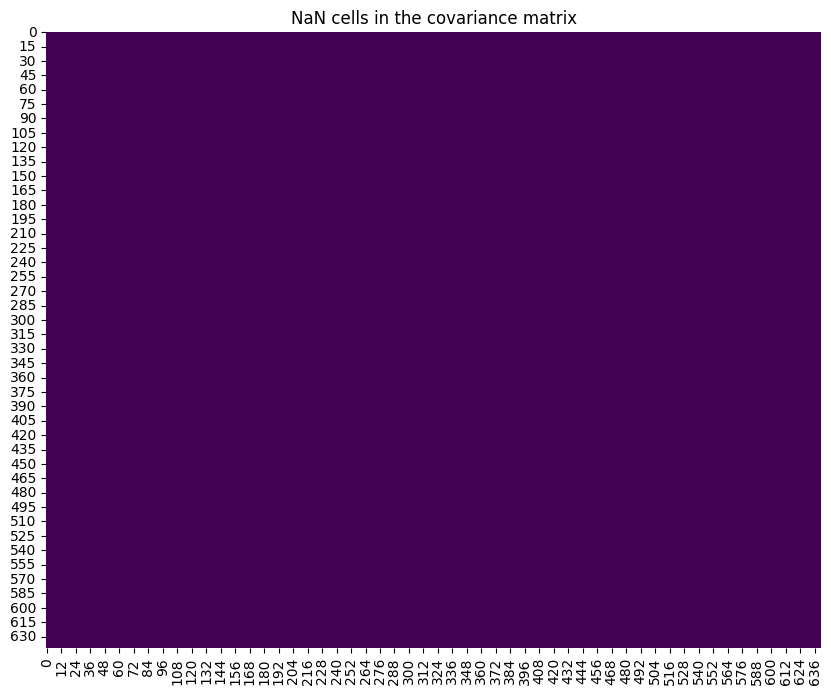

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(np.isnan(emp_cov_6_months), cbar=False, cmap='viridis')
plt.title('NaN cells in the covariance matrix')
plt.show()

## 6 months dataset

We apply the Graphical Lasso to the covariance matrix of the 6 months dataset.

In [ ]:
cov, pre = graphical_lasso(emp_cov_4_years, alpha=0.2, verbose=True, max_iter=5000, mode='cd', tol=0.001)

We visualize the precision matrix

/opt/anaconda3/envs/financial-stats/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/financial-stats/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


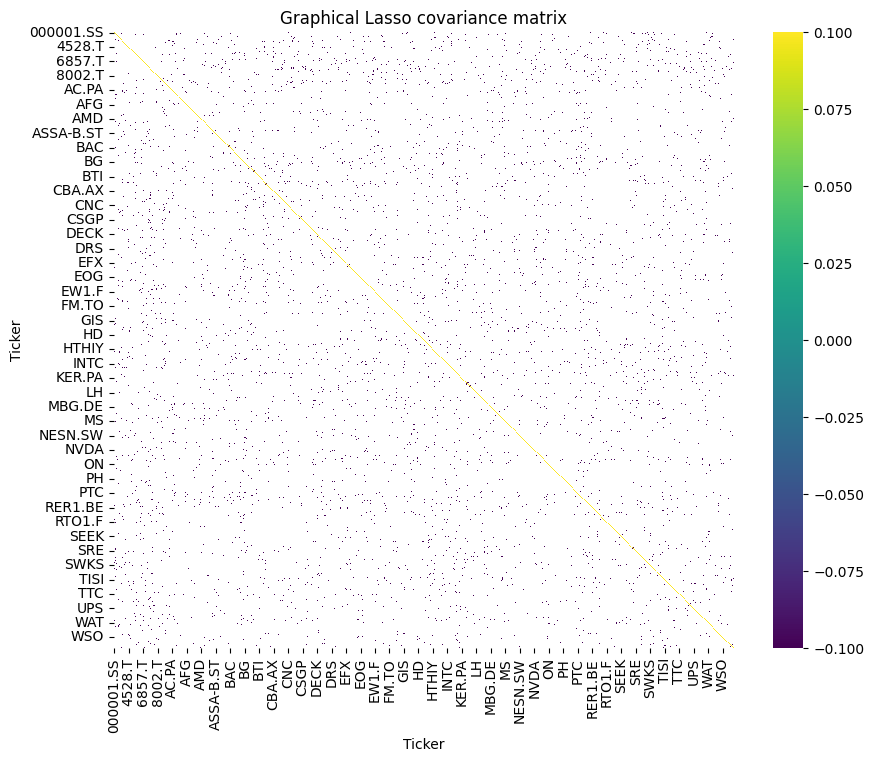

In [ ]:
pre = pd.DataFrame(pre, index=X_6_months.columns, columns=X_6_months.columns)
# Sns heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.log(pre), cmap='viridis')
plt.title('Graphical Lasso covariance matrix')
plt.show()

Our goal is now to find the optimal alpha value, we would like to find the value that gives us a precision matrix with 93% (± 5%) of the values equal to 0. We would also like to have a precision matrix that is stable over time. In order to check the stability of the precision matrix, we will make a rolling window of 4 months with a step of 1 week. We will first find an interval for alpha, which gives us a precision matrix with 93% (± 5%) of the values equal to 0. We will then use this interval to find the optimal alpha value according to the stability of the precision matrix.

In order to find the interval for alpha, we will use a dichotomy method. We will start with an interval of [0, 1].
We will make the average of the precision matrix sparsity over the rolling windows.

In [ ]:
minAlpha = 0.25
maxAlpha = 1
sparsity = 0.93
sparsity_delta = 0.05
sparsity_min = sparsity - sparsity_delta
sparsity_max = sparsity + sparsity_delta
n_assets = 150

First step, we will find the lower bound of the interval.

In [ ]:
def find_bound(minAlpha, maxAlpha, sparsity, window_size, step_size_days, X, epsilon=0.01, verbose=False):
    # We get the start and end date of the data
    start_date = X.index.min()
    end_date = X.index.max()
    # We get the end date for the window of size "window_size"
    end_initial_window = pd.to_datetime(start_date) + pd.DateOffset(months=window_size)
    print("Start date:", start_date)
    print("End initial window:", end_initial_window)
    num_windows = (int((pd.to_datetime(end_date) - pd.to_datetime(end_initial_window)).days / step_size_days)) + 1

    nb_iter = 0
    while True:
        sparsity_avg = 0
        alpha = (minAlpha + maxAlpha) / 2

        if verbose:
            print(f"Iteration {nb_iter}: alpha = {alpha}, sparsity = {sparsity_avg}, minAlpha = {minAlpha}, maxAlpha = {maxAlpha}, minAlpha - maxAlpha = {abs(maxAlpha - minAlpha)}")

        # For each window we compute the precision matrix and the sparsity
        for i in range(num_windows):
            # if verbose:
            #     tqdm.write(f"Window {i + 1}/{num_windows}")

            # We get the start and end date for the window
            start_window = pd.to_datetime(start_date) + pd.DateOffset(days=i * step_size_days)
            end_window = pd.to_datetime(start_window) + pd.DateOffset(months=window_size)

            if end_window > pd.to_datetime(end_date):
                raise ValueError("End window is out of range")

            # We get the data for the window
            X_window = X[(pd.to_datetime(X.index) >= start_window) & (pd.to_datetime(X.index) <= end_window)]

            # We need to restandardize the data in the window
            scaler = StandardScaler()
            X_window_std = scaler.fit_transform(X_window)

            # We compute the empirical covariance matrix using Ledoit-Wolf
            emp_cov, _ = ledoit_wolf(X_window_std, assume_centered=True)

            # We compute the precision matrix using Graphical Lasso
            _, prec_matrix = graphical_lasso(emp_cov, alpha=alpha, verbose=False, tol=1e-3)

            # We compute the sparsity of the precision matrix
            sparsity_matrix = np.sum(prec_matrix == 0) / prec_matrix.size
            # print(f"Sparsity matrix: {sparsity_matrix}")
            sparsity_avg += sparsity_matrix

        # We can now compute the average sparsity of the precision matrix on the windows
        sparsity_avg /= num_windows

        if verbose:
            print(f"Average sparsity: {sparsity_avg}")

        # If the average sparsity is less than the target sparsity, we need to increase alpha
        if sparsity_avg < sparsity:
            minAlpha = alpha
        else:
            # If the average sparsity is greater than the target sparsity, we need to decrease alpha
            maxAlpha = alpha

        # If the difference between minAlpha and maxAlpha is less than epsilon, we can stop
        if abs(maxAlpha - minAlpha) < epsilon:
            alpha = (minAlpha + maxAlpha) / 2
            break

        nb_iter += 1
    return alpha

In [ ]:
# Masquer les warnings de convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
alpha_lower_bound = find_bound(minAlpha, maxAlpha, sparsity_min, 12*3 + 5, 60, X_4_years_no_std.iloc[: ,:n_assets], epsilon=1e-5, verbose=True)

Start date: 2021-03-12
End initial window: 2024-08-12 00:00:00
Iteration 0: alpha = 0.625, sparsity = 0, minAlpha = 0.25, maxAlpha = 1, minAlpha - maxAlpha = 0.75
Average sparsity: 0.852711111111111
Iteration 1: alpha = 0.8125, sparsity = 0, minAlpha = 0.625, maxAlpha = 1, minAlpha - maxAlpha = 0.375
Average sparsity: 0.9022222222222223
Iteration 2: alpha = 0.71875, sparsity = 0, minAlpha = 0.625, maxAlpha = 0.8125, minAlpha - maxAlpha = 0.1875
Average sparsity: 0.8681777777777778
Iteration 3: alpha = 0.765625, sparsity = 0, minAlpha = 0.71875, maxAlpha = 0.8125, minAlpha - maxAlpha = 0.09375
Average sparsity: 0.8818888888888889
Iteration 4: alpha = 0.7421875, sparsity = 0, minAlpha = 0.71875, maxAlpha = 0.765625, minAlpha - maxAlpha = 0.046875
Average sparsity: 0.8745111111111111
Iteration 5: alpha = 0.75390625, sparsity = 0, minAlpha = 0.7421875, maxAlpha = 0.765625, minAlpha - maxAlpha = 0.0234375
Average sparsity: 0.8780888888888889
Iteration 6: alpha = 0.759765625, sparsity = 0, m

In [ ]:
alpha_upper_bound = find_bound(minAlpha, maxAlpha, sparsity_max, 12*3 + 5, 60, X_4_years_no_std.iloc[: ,:n_assets], epsilon=1e-5, verbose=True)

Start date: 2021-03-12
End initial window: 2024-08-12 00:00:00
Iteration 0: alpha = 0.625, sparsity = 0, minAlpha = 0.25, maxAlpha = 1, minAlpha - maxAlpha = 0.75
Average sparsity: 0.852711111111111
Iteration 1: alpha = 0.8125, sparsity = 0, minAlpha = 0.625, maxAlpha = 1, minAlpha - maxAlpha = 0.375
Average sparsity: 0.9022222222222223
Iteration 2: alpha = 0.90625, sparsity = 0, minAlpha = 0.8125, maxAlpha = 1, minAlpha - maxAlpha = 0.1875
Average sparsity: 0.9666
Iteration 3: alpha = 0.953125, sparsity = 0, minAlpha = 0.90625, maxAlpha = 1, minAlpha - maxAlpha = 0.09375
Average sparsity: 0.9902222222222222
Iteration 4: alpha = 0.9296875, sparsity = 0, minAlpha = 0.90625, maxAlpha = 0.953125, minAlpha - maxAlpha = 0.046875
Average sparsity: 0.9807777777777777
Iteration 5: alpha = 0.91796875, sparsity = 0, minAlpha = 0.90625, maxAlpha = 0.9296875, minAlpha - maxAlpha = 0.0234375
Average sparsity: 0.9739555555555556
Iteration 6: alpha = 0.923828125, sparsity = 0, minAlpha = 0.91796875, 

In [ ]:
print("Lower bound:", alpha_lower_bound, "Upper bound:", alpha_upper_bound)

Lower bound: 0.7596139907836914 Upper bound: 0.9281511306762695


Now we have the interval for alpha, we will use this interval to find the optimal alpha value according to the stability of the covariance matrix.
To compute to stability we will use the Frobenius norm of the difference between the covariance matrices of two consecutive windows. We will compute the average of this norm over all the windows. We will then find the alpha value that gives us the lowest average norm.

In [ ]:
def find_best_stability_alpha(alpha_lower_bound, alpha_upper_bound, window_size, step_size_days, X, grid_search_step=25, verbose=False, penalization_diag=1):
    start_date = X.index.min()
    end_date = X.index.max()
    end_initial_window = pd.to_datetime(start_date) + pd.DateOffset(months=window_size)
    num_windows = (int((pd.to_datetime(end_date) - pd.to_datetime(end_initial_window)).days / step_size_days)) + 1
    nb_iter = 0
    best_alpha = alpha_lower_bound
    best_stability = float('inf')

    steps_size = (alpha_upper_bound - alpha_lower_bound) / grid_search_step

    for h in range(grid_search_step):

        alpha = alpha_lower_bound + h * steps_size

        if verbose:
            print(f"Iteration {nb_iter}: alpha = {alpha}, best_alpha = {best_alpha}, best_stability = {best_stability}")

        stability_avg = 0
        no_shift_cov_matrix = None
        for i in range(num_windows):
            # if verbose:
            #     tqdm.write(f"Window {i + 1}/{num_windows}")
            start_window = pd.to_datetime(start_date) + pd.DateOffset(days=i * step_size_days)
            end_window = pd.to_datetime(start_window) + pd.DateOffset(months=window_size)
            if end_window > pd.to_datetime(end_date):
                raise ValueError("End window is out of range")
            X_window = X[(pd.to_datetime(X.index) >= start_window) & (pd.to_datetime(X.index) <= end_window)]


            scaler = StandardScaler()
            X_window_std = scaler.fit_transform(X_window)

            emp_cov, _ = ledoit_wolf(X_window_std, assume_centered=True)

            cov_matrix, _ = graphical_lasso(emp_cov, alpha=alpha, verbose=False, mode='cd', max_iter=1000, tol=1e-2)

            if i == 0:
                no_shift_cov_matrix = cov_matrix
                continue

            # Compute the Frobenius norm of the difference between the covariance matrices
            norm = np.linalg.norm(cov_matrix - no_shift_cov_matrix, ord='fro')

            stability_avg += norm
            no_shift_cov_matrix = cov_matrix
            # if verbose:
            #     print(f"Stability matrix: {norm}")

        stability_avg /= num_windows
        if verbose:
            print(f"Average stability: {stability_avg}")
        if stability_avg < best_stability:
            best_stability = stability_avg
            best_alpha = alpha
        nb_iter += 1

    return best_alpha, best_stability

In [ ]:
best_alpha, best_stability = find_best_stability_alpha(alpha_lower_bound, alpha_upper_bound, 12*3 + 5, 60, X_4_years_no_std.iloc[: ,:n_assets], grid_search_step=50, verbose=True)

Iteration 0: alpha = 0.7596139907836914, best_alpha = 0.7596139907836914, best_stability = inf
Average stability: 1.244369256138921
Iteration 1: alpha = 0.762984733581543, best_alpha = 0.7596139907836914, best_stability = 1.244369256138921
Average stability: 1.2176570026231766
Iteration 2: alpha = 0.7663554763793945, best_alpha = 0.762984733581543, best_stability = 1.2176570026231766
Average stability: 1.1911979729358921
Iteration 3: alpha = 0.769726219177246, best_alpha = 0.7663554763793945, best_stability = 1.1911979729358921
Average stability: 1.164901339865085
Iteration 4: alpha = 0.7730969619750977, best_alpha = 0.769726219177246, best_stability = 1.164901339865085
Average stability: 1.1387997306617885
Iteration 5: alpha = 0.7764677047729492, best_alpha = 0.7730969619750977, best_stability = 1.1387997306617885
Average stability: 1.11254108422477
Iteration 6: alpha = 0.7798384475708008, best_alpha = 0.7764677047729492, best_stability = 1.11254108422477
Average stability: 1.08620003

In [ ]:
print("Best alpha:", best_alpha, "Best stability:", best_stability)

Best alpha: 0.9273084449768066 Best stability: 0.11738288966867494


#### It seems that the stability optimization is not working as expected, as the norm will be decreasing with the number of non-zero values in the precision matrix. We will need to find a better way to compute the stability of the precision matrix.

If alpha = alpha_lower_bound

In [ ]:
def plot_precision_matrix(alpha, X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    emp_cov, _ = ledoit_wolf(X_scaled, assume_centered=True)
    _, prec_matrix = graphical_lasso(emp_cov, alpha=alpha, verbose=False, tol=1e-3)

    plt.figure(figsize=(10, 8))
    sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')
    plt.title('Precision matrix using Graphical Lasso with alpha = ' + str(alpha))
    plt.show()

/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')
/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: invalid value encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')


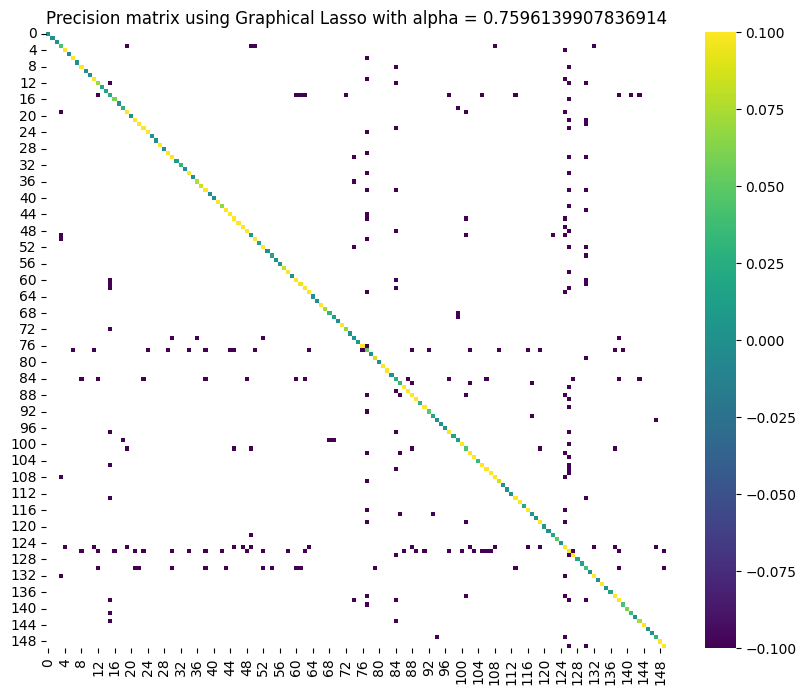

In [ ]:
plot_precision_matrix(alpha_lower_bound, X_4_years_no_std.iloc[: ,:n_assets])

If alpha = alpha_upper_bound

/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')
/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: invalid value encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')


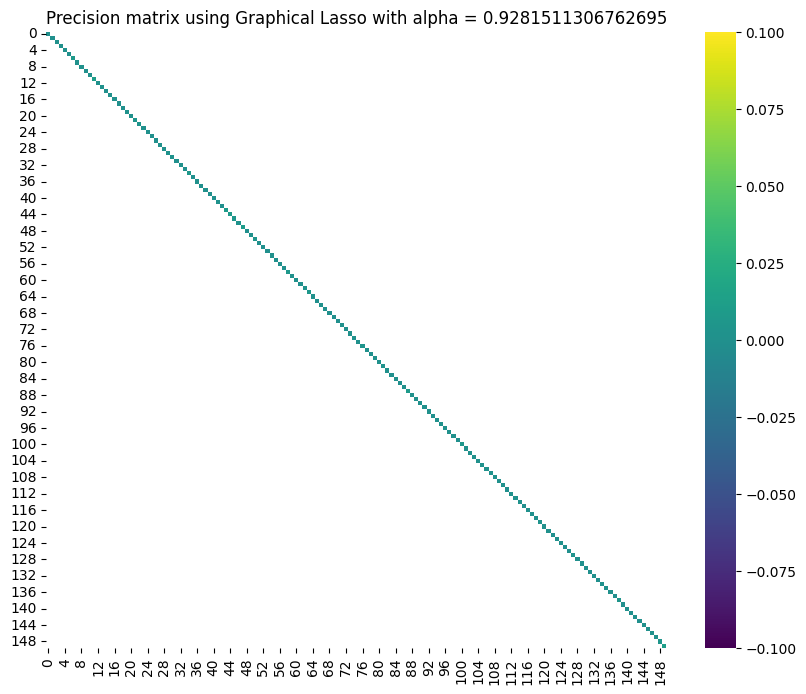

In [ ]:
plot_precision_matrix(alpha_upper_bound, X_4_years_no_std.iloc[: ,:n_assets])

/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')
/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: invalid value encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')


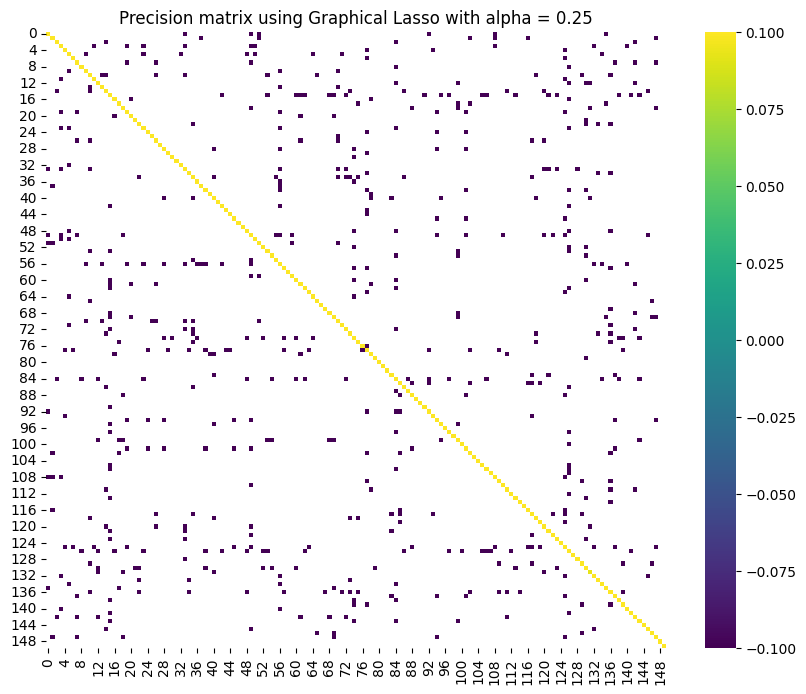

In [ ]:
plot_precision_matrix(minAlpha, X_4_years_no_std.iloc[: ,:n_assets])

/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')


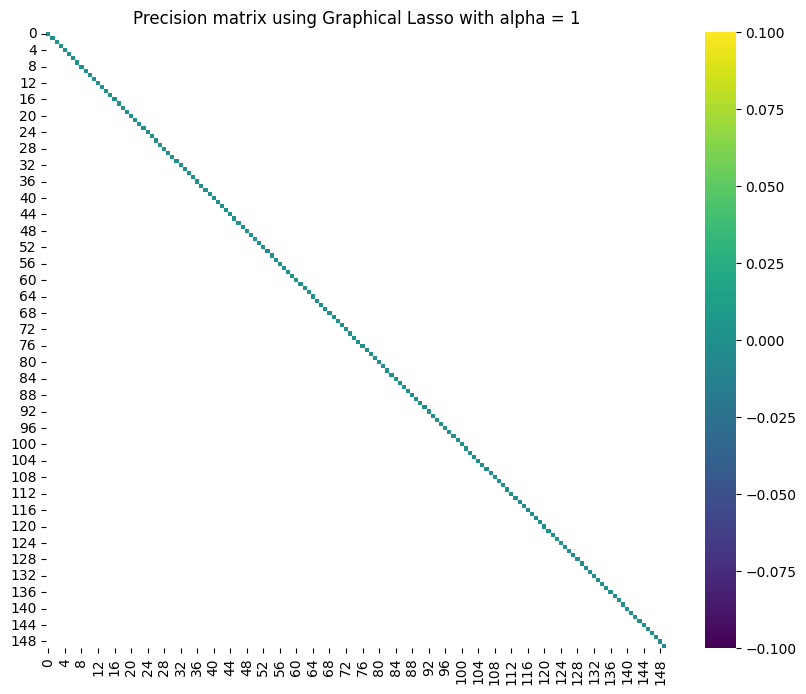

In [ ]:
plot_precision_matrix(maxAlpha, X_4_years_no_std.iloc[: ,:n_assets])

/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')
/var/folders/8c/5x_0dl_92msbw_907drg_1zc0000gn/T/ipykernel_8651/709495543.py:8: RuntimeWarning: invalid value encountered in log
  sns.heatmap(np.log(prec_matrix), cbar=True, cmap='viridis')


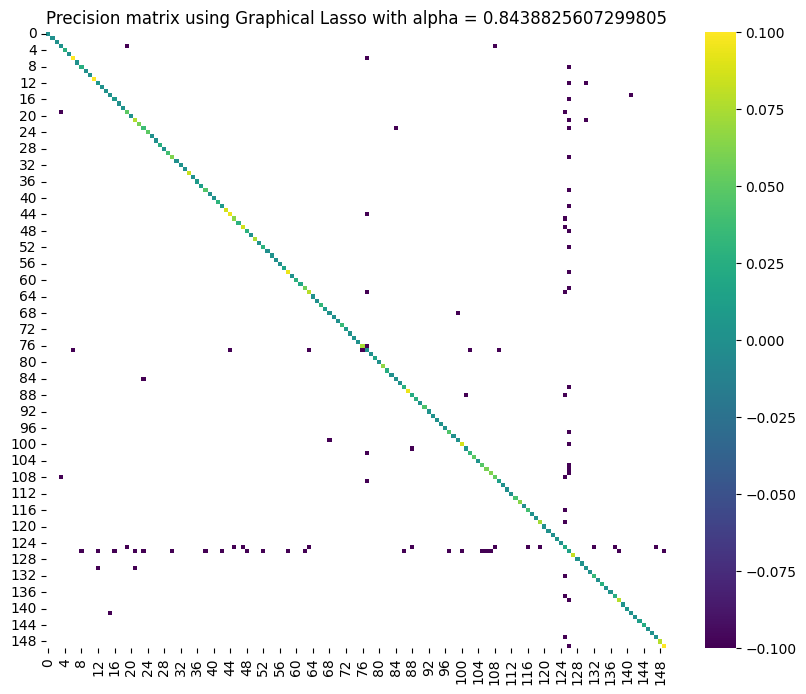

In [ ]:
plot_precision_matrix((alpha_lower_bound + alpha_upper_bound)/2, X_4_years_no_std.iloc[: ,:n_assets])